#### Importing libraries and dataset

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost
from xgboost.sklearn import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier

In [2]:
train_df= pd.read_csv('Train.csv')
test_df= pd.read_csv('Test.csv')

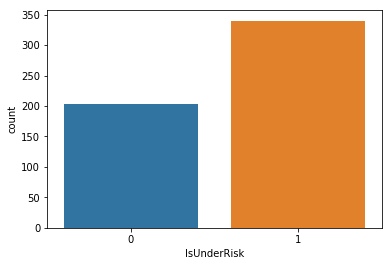

In [3]:
sns.countplot(train_df['IsUnderRisk'])

In [4]:
train_df.head()

,City,Location_Score,Internal_Audit_Score,External_Audit_Score,Fin_Score,Loss_score,Past_Results,IsUnderRisk
0,2,8.032,14,8,3,6,0,1
1,31,77.730,8,3,3,8,1,0
2,40,59.203,3,12,11,3,0,1
3,12,73.080,4,5,7,6,0,0
4,4,15.666,13,15,6,7,2,1


In [5]:
target = train_df['IsUnderRisk']
train_df.drop(columns= ['IsUnderRisk'], axis= 1, inplace= True)

In [ ]:
import pandas_profiling
# pandas_profiling.ProfileReport(train_df)

In [13]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(train_df,target, test_size= 0.3)

0.8098159509202454
6.568793022124257
0.8472906403940887
Feature: 0, Score: 0.09786
Feature: 1, Score: 0.20917
Feature: 2, Score: 0.30448
Feature: 3, Score: 0.17875
Feature: 4, Score: 0.12752
Feature: 5, Score: 0.06141
Feature: 6, Score: 0.02082


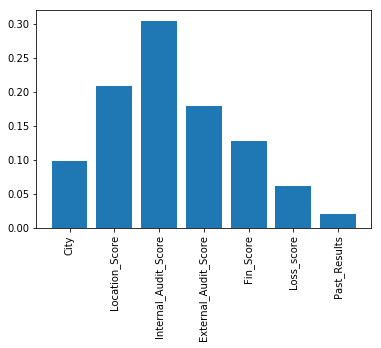

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss
from sklearn.metrics import f1_score

rfc = RandomForestClassifier(n_estimators=500)
rfc.fit(x_train, y_train)

print(rfc.score(x_test, y_test))
print(log_loss(y_test, rfc.predict(x_test)))
print(f1_score(y_test, rfc.predict(x_test)))

    
importance = rfc.feature_importances_

for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))


import matplotlib.pyplot as plt

plt.bar(train_df.columns, importance)
plt.xticks(rotation = 90)
plt.show()

0.8404907975460123
5.509311542557302
0.8725490196078431
Feature: 0, Score: 0.06902
Feature: 1, Score: 0.07159
Feature: 2, Score: 0.50448
Feature: 3, Score: 0.11925
Feature: 4, Score: 0.13537
Feature: 5, Score: 0.04614
Feature: 6, Score: 0.05415


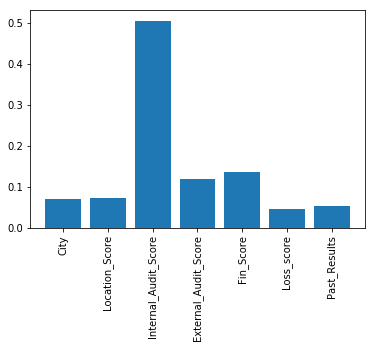

In [15]:
xgb = XGBClassifier()
xgb.fit(x_train, y_train)

print(xgb.score(x_test, y_test))
print(log_loss(y_test, xgb.predict(x_test)))
print(f1_score(y_test, xgb.predict(x_test)))

    
importance2 = xgb.feature_importances_

for i,v in enumerate(importance2):
	print('Feature: %0d, Score: %.5f' % (i,v))


import matplotlib.pyplot as plt

plt.bar(train_df.columns, importance2)
plt.xticks(rotation = 90)
plt.show()

In [16]:
train_df.columns

Index(['City', 'Location_Score', 'Internal_Audit_Score',
       'External_Audit_Score', 'Fin_Score', 'Loss_score', 'Past_Results'],
      dtype='object')

In [17]:
model = XGBClassifier()
model.fit(x_train, y_train)
y_pred= model.predict_proba(x_test)
score= log_loss(y_test, y_pred)
print('logloss', score)

logloss 0.31255066094411527


In [18]:
from sklearn.model_selection import GridSearchCV
model = XGBClassifier(random_state = 0)
n_estimators = range(50, 150, 10)
param_grid = {'learning_rate' : [0.1,0.2,0.01], 'n_estimators': n_estimators,'max_depth' : [3,4,5,6]}

grid_search = GridSearchCV(estimator = model, param_grid = param_grid , scoring = 'neg_log_loss')

grid_search.fit(train_df,target)

print("Best Score:" + str(grid_search.best_score_))
print("Best Parameters: " + str(grid_search.best_params_))
best_parameters = grid_search.best_params_


C:\Users\JYOTI\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Best Score:-0.28774842810019524
Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 60}


C:\Users\JYOTI\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [19]:
model = XGBClassifier(**best_parameters)
model.fit(x_train, y_train)
y_pred= model.predict_proba(x_test)
score= log_loss(y_test, y_pred)
print('logloss', score)

logloss 0.28694258037486053


In [20]:
xgb = XGBClassifier()
rf = RandomForestClassifier()
gb= GradientBoostingClassifier()

In [21]:
from sklearn.metrics import *
from vecstack import stacking

In [22]:
models = [
    DecisionTreeClassifier(criterion='entropy',splitter='best',max_depth=3,min_samples_split=2,max_features=None),
    
    GradientBoostingClassifier(),
        
    RandomForestClassifier(random_state=0, n_jobs=-1, 
                           n_estimators=100, max_depth=3),
        
    XGBClassifier(random_state=0, n_jobs=-1, learning_rate=0.1, 
                  n_estimators=100, max_depth=3) ,
    XGBClassifier(random_state=0, n_jobs=-1, learning_rate=0.1, 
                  n_estimators=60, max_depth=3) ,
    XGBClassifier(random_state=0, n_jobs=-1, learning_rate=0.1, 
                  n_estimators=90, max_depth=3)]

In [23]:
S_train, S_test = stacking(models, x_train, y_train,x_test, regression=False, mode='oof_pred_bag', 
                           needs_proba=False, metric=log_loss, n_folds=3, stratified=True, shuffle=True,
                           random_state=0, verbose=2)

task:         [classification]
n_classes:    [2]
metric:       [log_loss]
mode:         [oof_pred_bag]
n_models:     [6]

model  0:     [DecisionTreeClassifier]
    fold  0:  [5.98309512]
    fold  1:  [5.98314549]
    fold  2:  [5.48234546]
    ----
    MEAN:     [5.81619536] + [0.23606753]
    FULL:     [5.81707391]

model  1:     [GradientBoostingClassifier]
    fold  0:  [4.35139228]
    fold  1:  [4.62335744]
    fold  2:  [4.66003806]
    ----
    MEAN:     [4.54492926] + [0.13766818]
    FULL:     [4.54462634]

model  2:     [RandomForestClassifier]
    fold  0:  [6.25514214]
    fold  1:  [5.98314549]
    fold  2:  [4.38591444]
    ----
    MEAN:     [5.54140069] + [0.82456328]
    FULL:     [5.54444144]

model  3:     [XGBClassifier]
    fold  0:  [4.89531631]
    fold  1:  [5.43923405]
    fold  2:  [4.66003172]
    ----
    MEAN:     [4.99819403] + [0.32631982]
    FULL:     [4.99908393]

model  4:     [XGBClassifier]
    fold  0:  [5.43923405]
    fold  1:  [5.43922146]
   

In [24]:
model = GradientBoostingClassifier()
    
model = model.fit(S_train, y_train)
pred_test = model.predict_proba(S_test)
score = log_loss(y_test,pred_test)
print('logloss',score)

logloss 0.34668020566781715


In [25]:
model = XGBClassifier(**best_parameters)
# model =xgb
model = model.fit(S_train, y_train)
pred_test = model.predict_proba(S_test)
score = log_loss(y_test,pred_test)
print('logloss',score)

logloss 0.32402388586954106


In [26]:
S_train, S_test = stacking(models, train_df, target,test_df, regression=False, mode='oof_pred_bag', 
                           needs_proba=True, metric=log_loss, n_folds=3, stratified=True, shuffle=True, 
                           random_state=0, verbose=2)

task:         [classification]
n_classes:    [2]
metric:       [log_loss]
mode:         [oof_pred_bag]
n_models:     [6]

model  0:     [DecisionTreeClassifier]
    fold  0:  [0.38785844]
    fold  1:  [0.31348614]
    fold  2:  [0.30044476]
    ----
    MEAN:     [0.33392978] + [0.03850320]
    FULL:     [0.33409076]

model  1:     [GradientBoostingClassifier]
    fold  0:  [0.31543114]
    fold  1:  [0.30834802]
    fold  2:  [0.29581583]
    ----
    MEAN:     [0.30653166] + [0.00811026]
    FULL:     [0.30656779]

model  2:     [RandomForestClassifier]
    fold  0:  [0.38858020]
    fold  1:  [0.34379787]
    fold  2:  [0.33988935]
    ----
    MEAN:     [0.35742247] + [0.02208955]
    FULL:     [0.35751214]

model  3:     [XGBClassifier]
    fold  0:  [0.31177380]
    fold  1:  [0.27952271]
    fold  2:  [0.27939081]
    ----
    MEAN:     [0.29022911] + [0.01523450]
    FULL:     [0.29028874]

model  4:     [XGBClassifier]
    fold  0:  [0.32072863]
    fold  1:  [0.28061103]
   

In [27]:
model = XGBClassifier(**best_parameters)
    
model = model.fit(S_train, target)
pred_test = model.predict_proba(S_test)
output = pd.DataFrame({'0': pred_test[:,0],'1': pred_test[:,1]})
output.to_excel('Financialriskpredsubmission.xlsx',sheet_name= 'Sheet1', index=False)
output.head()

,0,1
0,0.002973,0.997027
1,0.002973,0.997027
2,0.898768,0.101232
3,0.002973,0.997027
4,0.013285,0.986715
